<a href="https://colab.research.google.com/github/csralvall/online_game_toxicity/blob/main/clustering_ftt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import utility functions

In [1]:
from IPython.display import clear_output

### Install dependencies

In [2]:
# install dependencies
!pip install -U pip setuptools wheel pandas numpy gensim wget
clear_output()

### Import libraries

In [3]:
# import libraries
from google.colab import drive
import pandas as pd
import numpy as np
import pickle
import sklearn.manifold
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from collections import Counter
from gensim.models import FastText

### Setup dataframe print options

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### Mount storage

In [5]:
# mount google drive unit to save computationally expensive results
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load subset of whole dataset from storage

In [6]:
# english chats from original dataset with anotations
eng_annotated = '/content/drive/MyDrive/nlp/dota2_chat_eng_annotated_2.csv'
df_test = pd.read_csv(eng_annotated)[:10000].dropna().reset_index(drop=True)

### Get bad word list from memory

In [7]:
# get downloaded bad word list
word_list = "/content/drive/MyDrive/nlp/bad_words.txt"
# use set for fast queries
bad_words = set(line.strip() for line in open(word_list, 'r'))
# add new bad words
bad_words.update(['noob', 'noobs', 'stfu', 'fukign', 'fuking', 'fukin', 'nooob'])
bad_dict = dict.fromkeys(bad_words, 0)

#### Fasttext embeddings:

In [8]:
# function to create embeddings of words in each chat
def generate_embedding_ftt(sentences: [[str]]):
  ftt_model = FastText(
      sentences=sentences,
      vector_size=100,
      window=5,
      min_count=1,
      workers=1
  )

  ftt_model.build_vocab(sentences, progress_per=10000)

  ftt_model.train(sentences, total_examples=len(sentences), epochs=100)

  return ftt_model

### Unroll chats as list of words

In [9]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [10]:
# from cleaned english chats get all of them without nan values
chats = df_test[['tokens']].dropna().astype(str).values
chats = flatten(chats)
vocab = list(map(lambda x: x.split(), chats))

### Generate word embeddings from chat

In [11]:
ftt_model = generate_embedding_ftt(vocab)

In [12]:
# save FastText model
ftt_model.save('/content/drive/MyDrive/nlp/fasttext.model')

### Load word embeddings from disk

In [13]:
# load FastText model
ftt_model = FastText.load('/content/drive/MyDrive/nlp/fasttext.model')

### Embeddings utils

In [14]:
# generate embedding from chat
def chat_embedding(model, chat_words):
    chat_embedding = np.ones(100)
    for word in chat_words:
        if word in model.wv:
            chat_embedding *= model.wv[word] 
    return chat_embedding

### Clustering utils

In [15]:
def get_bad_vec(lexicon, chat_words):
    for word in chat_words:
        if word in lexicon:
            lexicon[word] += 1

    bad_vec = np.fromiter(lexicon.values(), dtype=int)
    
    return bad_vec

In [16]:
def get_bow_vec(bow, chat_words):
    for word in chat_words:
        if word in bow:
            bow[word] += 1

    bow_vec = np.fromiter(bow.values(), dtype=int)

    return bow_vec

In [17]:
intensity = df_test[['intensity']].copy()

### Create ftt vectors for clustering

In [18]:
ftt_serie = np.array([])
for idx, chat in enumerate(chats):
    lexicon = dict.fromkeys(bad_words, 0)
    chat_intensity = intensity.loc[idx]
    chat_words = chat.split()
    bad_vec = get_bad_vec(lexicon, chat_words)
    ftt_embedding = chat_embedding(ftt_model, chat_words)
    ftt_bad_int_vec = np.hstack((ftt_embedding, bad_vec, chat_intensity)).ravel()
    ftt_serie = np.concatenate((ftt_serie, ftt_bad_int_vec))

### Reshape data

In [19]:
ftt_ncolumns = ftt_model.wv.vectors.shape[1] + len(bad_words) + 1
ftt_serie = ftt_serie.astype('float').reshape((-1, ftt_ncolumns))
ftt_matrix = ftt_serie[~np.isnan(ftt_serie)].reshape((-1, ftt_ncolumns))

### Matrix reduction

In [20]:
def reduce_matrix(matrix: np.ndarray, *, variance_treshold: float):
    print(f'INPUT SHAPE: {matrix.shape}')
    # reduce all vectors to [0, 1] space
    normalized_matrix = normalize(matrix, axis=1)
    # compute variances in each row
    matrix_variances = np.var(matrix, axis=0)
    # create mask for features with high correlation (low variance)
    bool_mask = np.where(matrix_variances < variance_treshold)
    # filter features with high correlation (variance under treshold)
    raked_matrix = np.delete(normalized_matrix, bool_mask, axis=1)
    print(f'OUTPUT SHAPE: {raked_matrix.shape}')
    return raked_matrix

In [21]:
ftt_reduced = reduce_matrix(ftt_matrix, variance_treshold=0.01)

INPUT SHAPE: (10000, 1492)
OUTPUT SHAPE: (10000, 106)


### Save matrix

In [22]:
with open('/content/drive/MyDrive/nlp/ftt_serie_10000.npy', 'wb') as output_file:
    np.save(output_file, ftt_reduced)

### Load matrix from storage

In [23]:
ftt_reduced = np.load('/content/drive/MyDrive/nlp/ftt_serie_10000.npy')

### Clustering

In [24]:
def generate_clusters(
    matrix: np.ndarray,
    n_clusters: int
) -> KMeans:
    # generate word clusters using the KMeans algorithm.
    print("\nClustering started")
    # Instantiate KMeans clusterer for n_clusters
    km_model = KMeans(n_clusters=n_clusters, random_state=3)
    # create clusters
    km_model.fit(matrix)
    print("Clustering finished")
    return km_model

### Create clusters

In [25]:
ftt_clusters = generate_clusters(ftt_reduced, 100)


Clustering started
Clustering finished


### Cluster utility functions

In [26]:
def display_summary(clusters: KMeans):
    cluster_count = Counter(sorted(clusters.labels_))
    for cluster in cluster_count:
        print ("Cluster#", cluster," - Total words:", cluster_count[cluster])

In [27]:
def annotate_dataframe(clusters: KMeans, df: pd.DataFrame, col_name: str):
    cluster_count = Counter(sorted(clusters.labels_))
    #sort cluster centers by proximity to centroid
    order_centroids = clusters.cluster_centers_.argsort()[:, ::-1] 

    clusters_df = np.zeros(len(df))
    
    for cluster_idx in cluster_count:
        # get words inside each cluster
        cluster_words = np.where(clusters.labels_ == cluster_idx)[0]
        # anotate all chats in cluster
        for idx in cluster_words:
            clusters_df[idx] = int(cluster_idx)

    df[col_name] = clusters_df

### Show info about clusters

In [28]:
display_summary(ftt_clusters)

Cluster# 0  - Total words: 43
Cluster# 1  - Total words: 47
Cluster# 2  - Total words: 76
Cluster# 3  - Total words: 228
Cluster# 4  - Total words: 104
Cluster# 5  - Total words: 123
Cluster# 6  - Total words: 99
Cluster# 7  - Total words: 71
Cluster# 8  - Total words: 94
Cluster# 9  - Total words: 155
Cluster# 10  - Total words: 25
Cluster# 11  - Total words: 112
Cluster# 12  - Total words: 288
Cluster# 13  - Total words: 115
Cluster# 14  - Total words: 107
Cluster# 15  - Total words: 174
Cluster# 16  - Total words: 96
Cluster# 17  - Total words: 127
Cluster# 18  - Total words: 140
Cluster# 19  - Total words: 187
Cluster# 20  - Total words: 71
Cluster# 21  - Total words: 76
Cluster# 22  - Total words: 83
Cluster# 23  - Total words: 109
Cluster# 24  - Total words: 156
Cluster# 25  - Total words: 73
Cluster# 26  - Total words: 69
Cluster# 27  - Total words: 104
Cluster# 28  - Total words: 39
Cluster# 29  - Total words: 179
Cluster# 30  - Total words: 83
Cluster# 31  - Total words: 88
Cl

### Annotate cluster for each row in dataframe

In [29]:
df_test = df_test.copy()

In [30]:
annotate_dataframe(ftt_clusters, df_test, 'ftt_clusters')

In [31]:
df_test['nwords'] = list(map(lambda x: len(x.split()), df_test['tokens']))

In [32]:
df_test.to_csv(f'/content/drive/MyDrive/nlp/ftt_clusters_df.csv', index=False)

### Load FastText clusters

In [33]:
df_test = pd.read_csv('/content/drive/MyDrive/nlp/ftt_clusters_df.csv')

### Explore results

In [34]:
ftt_group = df_test.groupby('ftt_clusters')

Shilouette coeficient for this clustering

In [35]:
metrics.silhouette_score(ftt_reduced, ftt_clusters.labels_, metric='euclidean')

0.07133494270115544

Get toxicity score for each cluster

In [36]:
ftt_score = (ftt_group['toxicity'].sum() / ftt_group['nwords'].sum())
ftt_scored = pd.DataFrame({'score': ftt_score.values, 'size': ftt_group.size()})
ftt_scored = ftt_scored[ftt_scored['score'] > 0.2]
ftt_scored = ftt_scored.sort_values(by=['score', 'size'], ascending=[False, False])
top_toxic_clusters = ftt_scored.index.to_list()
ftt_scored

,score,size
ftt_clusters,,
55.0,0.631579,19
33.0,0.627119,39
80.0,0.625000,22
2.0,0.391813,76
68.0,0.354167,67
43.0,0.317757,44
25.0,0.270588,73
41.0,0.260771,133
7.0,0.245989,71


### Explore clusters

In [46]:
ftt_group.get_group(55)[['match','text']]

,match,text
260,121,you are shit
2009,1249,had to take a shit
2578,1504,name of the ship
2678,1552,thats shit
3113,1797,youre shit
3121,1797,why is ur name shit
3304,1906,and cant do shit
3935,2347,i have the shittiest
4752,2793,with this shitshiow
5090,2975,i dont give shit


In [47]:
ftt_group.get_group(33)[['match','text']]

,match,text
131,82,Ima out to fuck
235,121,what the fuck
244,121,what the fuck
685,368,It fucked me more than you.
1099,612,get the fuck out
1318,796,what the fukc
1359,823,willow can't admit she fucked u
1590,981,what the fucl
1639,1033,bc fuck u thats y
1799,1122,what the fuck


In [48]:
ftt_group.get_group(80)[['match','text']]

,match,text
116,71,I WOULD HAVE KILL HIM
1609,1002,I won0't kill you
2019,1249,you kill top[
2213,1345,how i kill all of you
2323,1395,or again kill you
3247,1877,didnt even get the kill
3346,1955,gj. I can't kill you all
3930,2347,just go kill him
4387,2586,8k mmr can'ty even get a kill in these lobbies
4533,2659,u kill him so much


In [49]:
ftt_group.get_group(2)[['match','text']]

,match,text
114,71,FUCK THIS PANGO
203,107,i fuck your mum
307,153,where the fuck is snow
473,235,SHUT THE FUCK UP
722,378,cant fuck with oracle!
1152,678,fuck your mom
1265,736,who ther fuck gets bkb in LP?
1364,826,fuck off dudes
1469,915,what the fuck is your problem with m?
1473,916,she gay and she fucked u


In [50]:
ftt_group.get_group(68)[['match','text']]

,match,text
83,43,that was more lucky than ur kill 😂:D
205,107,make sure u can kill me 1st
253,121,16 kills still lose
279,129,but my teammates wont to kill u((9(
481,235,nice fair matchmaking
763,409,nice first kill
1023,555,then worth less than creeps
1122,636,u go kill then quit?
1145,671,and u didnt kill me its necro
1267,736,i dont think this sf knows he was an ult


### Reduce dimensionality to display data

In [42]:
# use TSNE to reduce dimensionality of data
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(ftt_reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


### Display data without clusters

In [43]:
pointsspacy = pd.DataFrame(
    [(chat, coord[0], coord[1]) for (chat, coord) in zip(chats, matrix_dicc2d)],
    columns=["word", "x", "y"]
)

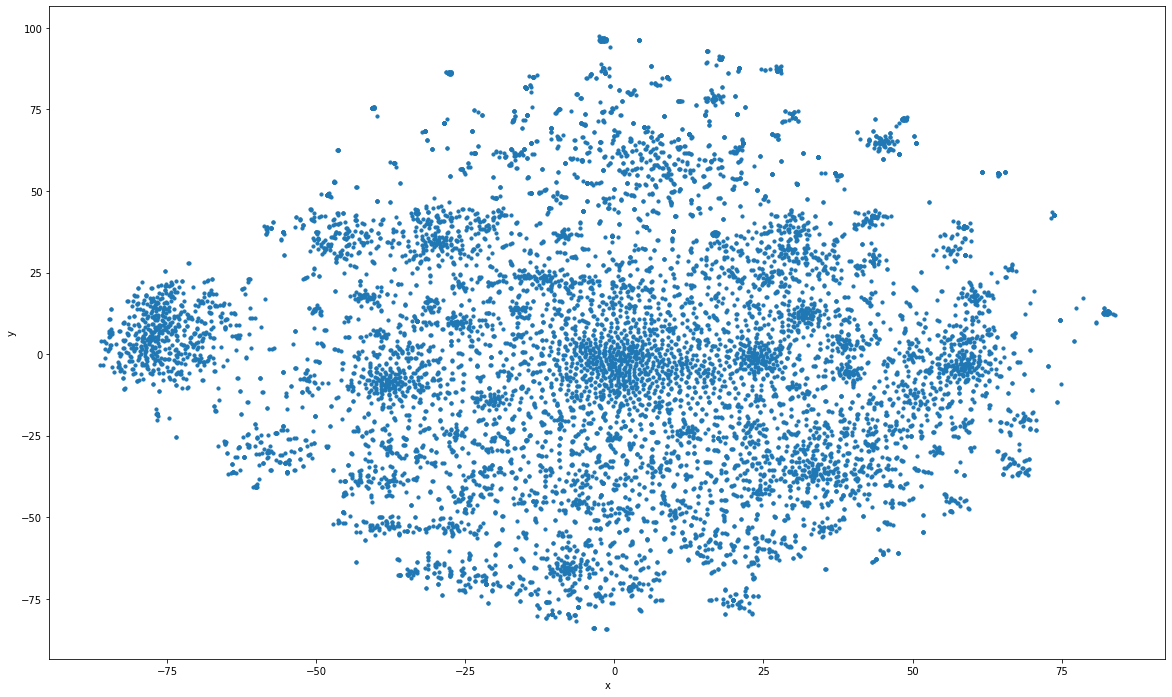

In [44]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

### Display clusters and clusters with biggest proportion of toxic words

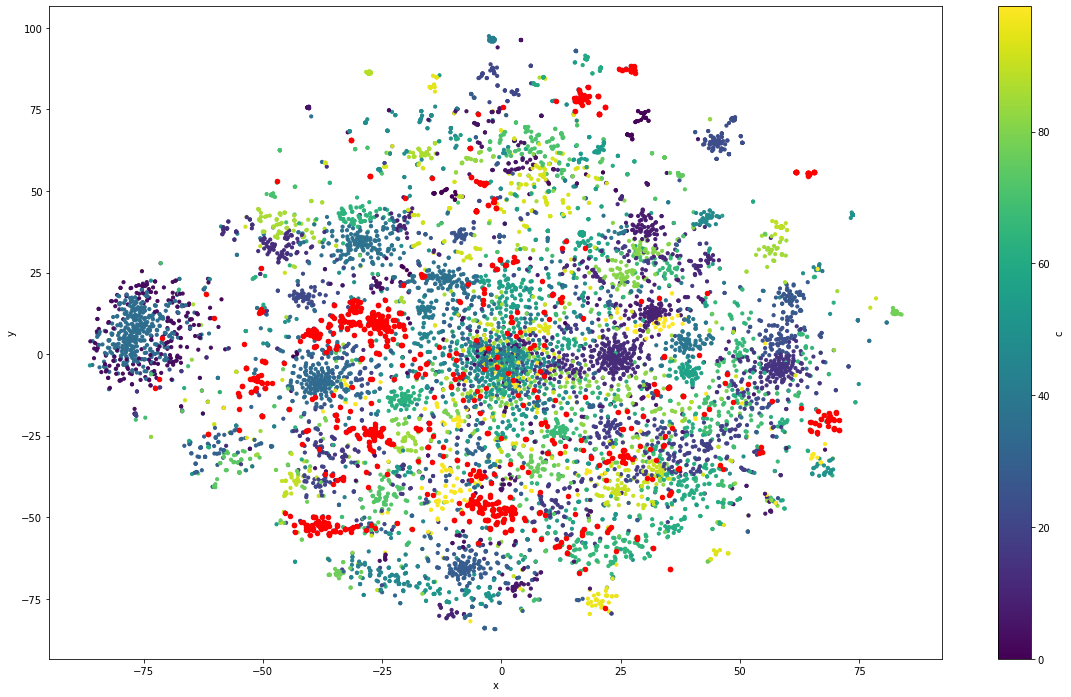

In [45]:
fig, ax = plt.subplots()
pointscluster = pd.DataFrame(
    [(chat, coord[0], coord[1], cluster) for (chat, coord, cluster) in zip(df_test['clean'], matrix_dicc2d, df_test['ftt_clusters']) ],
    columns=["word", "x", "y", "c"]
)
pointscluster.plot(ax=ax, kind='scatter', x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))
toxic_clusters = pd.DataFrame(
    [(coord[0], coord[1]) for (coord, cluster) in zip(matrix_dicc2d, df_test['ftt_clusters']) if cluster in top_toxic_clusters ],
    columns=["x", "y"]
)
toxic_clusters.plot(ax=ax, kind='scatter', x='x', y='y', color='red')
plt.show()